<a href="https://colab.research.google.com/github/abdalrahman9/back_physio/blob/master/Python_Code/Feature_Extraction_Bender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uploading the data into the envirnment

In [ ]:
from matplotlib import interactive, pyplot as plt
import numpy as np
import math #needed for definition of pi
import pandas as pd
import time, datetime, csv, signal
import os
import re
from seglearn.transform import InterpLongToWide
from seglearn.transform import FeatureRep, Segment, Interp
from seglearn.pipe import Pype
from bokeh.models import ColumnDataSource, Grid, LinearAxis, MultiLine, Plot, Range1d, LayoutDOM

In [ ]:
from matplotlib import interactive, pyplot as plt
import numpy as np
import math #needed for definition of pi
import pandas as pd
import time, datetime, csv, signal
import os
import re
from seglearn.transform import InterpLongToWide
from seglearn.transform import FeatureRep, Segment, Interp
from seglearn.pipe import Pype
from bokeh.models import ColumnDataSource, Grid, LinearAxis, MultiLine, Plot, Range1d, LayoutDOM



def signal_dataframe(folder):
  items = folder.split('/')
  session_name = items[1]+"_"+items[2]+"_"+items[3]+"_"+items[4]
  '''###
  MERGE CODE
  '''###
  for id_sensor , (sensor,sensor_name) in enumerate(zip([A,B,C,D,E,F,G,H],['A','B','C','D','E','F','G','H'])):
    if 'reps' in items:
        ending = "_"+items[6]+".csv"
    else:
        ending = ".csv"


    dfa = pd.read_csv(folder+session_name+'_'+sensor.replace(':','')+'_acc'+ending) #Reading the dataset in a dataframe using Pandas
    dfg = pd.read_csv(folder+session_name+"_"+sensor.replace(':','')+"_gyro"+ending) #Reading the dataset in a dataframe using Pandas
    dfm = pd.read_csv(folder+session_name+"_"+sensor.replace(':','')+"_mag"+ending) #Reading the dataset in a dataframe using Pandas
    dfq = pd.read_csv(folder+session_name+"_"+sensor.replace(':','')+"_quat"+ending) #Reading the dataset in a dataframe using Pandas
    dfp = pd.read_csv(folder+session_name+"_"+sensor.replace(':','')+"_pres"+ending) #Reading the dataset in a dataframe using Pandas

    for signal_id , signal in enumerate([dfa,dfg,dfm,dfq,dfp]):
      #Drop Time column
      signal.drop(columns=['time (-07:00)'],inplace=True)

      #Switch order of elapsed time and epoch
      cols  = list(signal.columns)
      cols[0], cols[1] = cols[1] , cols[0]
      signal = signal[cols]

      #Interpolate the data to have all signals to 25Hz
      clf = Pype([('interp', Interp(1. / 25., categorical_target=True))])
      # print(signal[cols].columns.values[1:])
      # test = ([dfa.to_numpy(),dfg.to_numpy(),dfm.to_numpy(),dfq.to_numpy(),dfp.to_numpy()])
      signal_arr, _ = clf.fit_transform([signal.to_numpy()],[0])
      signal_arr = pd.DataFrame(data=signal_arr[0],columns=signal[cols].columns.values[1:])
      if signal_id == 0:
        dfa =  signal_arr
      elif signal_id == 1:
        dfg =  signal_arr
      elif signal_id == 2:
        dfm =  signal_arr
      elif signal_id == 3:
        dfq =  signal_arr
      else:
        dfp =  signal_arr

    #Synchronizing and merging the signals together
    test1a = pd.merge_asof(dfa, dfg, on='epoch (ms)')
    test2a = pd.merge_asof(test1a, dfm, on='epoch (ms)')
    test3a = pd.merge_asof(test2a, dfq, on='epoch (ms)')
    test4a = pd.merge_asof(test3a, dfp, on='epoch (ms)')

    df = test4a

    #Add sensor name to each of its corresponding columns
    for signal in sensor_type_col_labels:
      for axis in signal:
        df.rename(columns = {axis:axis + " - "+ sensor_name}, inplace = True)
        
    if id_sensor == 0:
      full_df = df.copy()
    else:
      full_df = pd.merge_asof(full_df, df, on='epoch (ms)')

  # Remove any NA rows and reset index before returning array
  full_df.dropna(inplace=True)
  full_df.reset_index(drop=True, inplace=True)

  #Taring epochs to first epoch entry (eg. Epoch[0] = 0 ms) 
  full_df['epoch (ms)'] = ((full_df['epoch (ms)']).sub(full_df['epoch (ms)'][0])).div(1000)

  #Convert dataframe to ndarray and return it
  return full_df.to_numpy()


################################### MAIN CODE ######################################
#1 Laying Down
#2 Sustained Extension
#4 Sagittal Extension
#5 Extension in Standing
#6 Flexion in Lying
#7 Flexion in Sitting
#8 Flexion in Standing
#9 Side Glide in Laying
#10 Side Glide in Standing
#11 Rotation Flexion Knees Together
#12 Rotation Flexion One leg stretch
#13 Other

###Define Global variables and arrays###

#Sensor MAC
A = "C7:E1:38:1F:C0:DE"
B = "F4:04:52:A2:CB:59"
C = "E3:62:1F:8B:81:B7"
D = "E8:9C:A5:A3:8A:60"
E = "F9:0E:1C:DA:D4:1D"
F = "CD:A5:4D:78:A1:B4"
G = "EF:AA:47:DC:45:44"
H = "CD:78:F1:6B:D8:67"

#Channel names
acc_col_label = ['X-Axis (g)','Y-Axis (g)','Z-Axis (g)']
gyro_col_label =['X-Axis (deg/s)','Y-Axis (deg/s)','Z-Axis (deg/s)']
mag_col_label = ['X-Axis (T)','Y-Axis (T)','Z-Axis (T)']
pres_col_label = ['Pressure (Pa)']
quat_col_label = ['W-Axis','X-Axis (i)','Y-Axis (j)','Z-Axis (k)'] #should be i j k
sensor_type_col_labels = [acc_col_label,gyro_col_label,mag_col_label,quat_col_label,pres_col_label]

#Selecting the Participant Data that wants to be analyzed 
subj_names = ['p0','p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14','p15','p16','p17','p18']

#Defining the data dict that will house the imported data
data = {'X': [], 'Subject': [], 'Exercise': [], 'Side': [], 'Rep': [], 'Sensor': [], 'Signal' : [], 'Axis': [], 'Y': []}

#Specify data folder
directory = "Data/"

#Important the relevent data files into the data dict
for subj in subj_names:	#Enter Subject Folder
    folder = directory + subj + "/"   #update folder string with new directory

    #Loop only with newest session with "[max(os.listdir(folder))]"
    for session in [s for s in [max(os.listdir(folder))] if os.path.isdir(folder+s)]:	#Enter Session Folder
        folder = directory + subj + "/" + session + "/"   #update folder string with new directory

        #Loop through each exercise folder except for nonrelevent folders (eg. tar & test folders)
        #Change which folders you want to exclude based on which data you want (Desire all data or only posture or exercise)
        for exercise in [e for e in os.listdir(folder) if os.path.isdir(folder+e) and e!='tar' and e!='test' and e!='offset' and e!='pg' and e!='pfg' and e!='pb']: 
                        #  and e!='e1' and e!='e2' and e!='e3' and e!='e4' and e!='e5' and e!='e6' and e!='e7' and e!='random']:	#Enter Exercise Folder
            folder = directory + subj + "/" + session + "/" + exercise + "/"    #update folder string with new directory

            #Extract all Round Folders and select the newest round
            round_folders = [r for r in os.listdir(folder) if os.path.isdir(folder+r)]
            #First check 2 sided exercises
            if exercise in ['e3','e4','e7']:  #Where there are 2 sides (L/R)
                left = [place for place in round_folders if 'l' in place]
                right = [right for right in round_folders if right not in left]
                if not left:
                    round_folders = [max(right)]
                elif not right:
                    round_folders = [max(left)]
                else:
                    round_folders = [max(left),max(right)]
            #Next check One sided exercises
            else:# One sided Exercises
                round_folders = [max(round_folders)]

            #Now enter Round folder
            for rounds in round_folders:	#Enter Round Folder
                folder = directory + subj + "/" + session + "/" + exercise + "/" + rounds + "/"   #update folder string with new directory
                
                #Check if there is a reps folder
                if os.path.isdir(folder+"reps"): #Check if there is a reps folder
                    folder = directory + subj + "/" + session + "/" + exercise + "/" + rounds + "/reps/"
                    for reps in [r for r in os.listdir(folder) if os.path.isdir(folder+r)]:
                        folder = directory + subj + "/" + session + "/" + exercise + "/" + rounds + "/reps/" + reps + "/"
                        
                        #Extract data from files and label the entry with the correspoding data & tags
                        all_signals = signal_dataframe(folder)
                        data['X'].append(all_signals)
                        data['Subject'].append((re.findall(r"\d+", subj))[0])
                        data['Exercise'].append(exercise)
                        data['Rep'].append(int(reps)+1)

                        #If exercise has 2 sides, put the applicable side
                        if 'l' in rounds:
                            data['Side'].append('Left')
                        elif rounds.count('r') == 2:
                            data['Side'].append('Right')
                        else:
                            data['Side'].append('NA')
                        print("Saved "+folder)

                #For exercises with no reps (ex. pg & e1)
                else:	#No Reps Folder Found
                      #Extract data from files and label the entry with the correspoding data & tags
                      all_signals = signal_dataframe(folder)
                      data['X'].append(all_signals)
                      data['Subject'].append((re.findall(r"\d+", subj))[0])
                      data['Exercise'].append(exercise)
                      data['Rep'].append(1)
                      
                      #If exercise has 2 sides, put the applicable side
                      if 'l' in rounds:
                          data['Side'].append('Left')
                      elif rounds.count('r') == 2:
                          data['Side'].append('Right')
                      else:
                          data['Side'].append('NA')
                      print("Saved "+folder)

#Save all the labels into one key for easier manipulation later on
data['Y'] = np.column_stack([data['Subject'], data['Exercise'], data['Side'], data['Rep']])

#Output the sizes of the important data
print("Finished Saving Files")

print("# X " + str(len(data['X'])))
print("# Side " + str(len(data['Side'])))
print("# Subject " + str(len(data['Subject'])))
print("# Exercise " + str(len(data['Exercise'])))
print("# Rep " + str(len(data['Rep'])))

Saved Data/p0/s3/e5/r1/reps/4/
Saved Data/p0/s3/e5/r1/reps/2/
Saved Data/p0/s3/e5/r1/reps/5/
Saved Data/p0/s3/e5/r1/reps/3/
Saved Data/p0/s3/e5/r1/reps/1/
Saved Data/p0/s3/e5/r1/reps/0/
Saved Data/p0/s3/e1/r2/
Saved Data/p0/s3/e3/r1l/reps/4/
Saved Data/p0/s3/e3/r1l/reps/2/
Saved Data/p0/s3/e3/r1l/reps/5/
Saved Data/p0/s3/e3/r1l/reps/3/
Saved Data/p0/s3/e3/r1l/reps/1/
Saved Data/p0/s3/e3/r1l/reps/0/
Saved Data/p0/s3/e3/r1r/reps/4/
Saved Data/p0/s3/e3/r1r/reps/2/
Saved Data/p0/s3/e3/r1r/reps/5/
Saved Data/p0/s3/e3/r1r/reps/3/
Saved Data/p0/s3/e3/r1r/reps/1/
Saved Data/p0/s3/e3/r1r/reps/0/
Saved Data/p0/s3/e2/r1/reps/4/
Saved Data/p0/s3/e2/r1/reps/2/
Saved Data/p0/s3/e2/r1/reps/3/
Saved Data/p0/s3/e2/r1/reps/1/
Saved Data/p0/s3/e2/r1/reps/0/
Saved Data/p0/s3/e6/r2/reps/4/
Saved Data/p0/s3/e6/r2/reps/2/
Saved Data/p0/s3/e6/r2/reps/5/
Saved Data/p0/s3/e6/r2/reps/3/
Saved Data/p0/s3/e6/r2/reps/1/
Saved Data/p0/s3/e6/r2/reps/0/
Saved Data/p0/s3/e4/r1l/reps/4/
Saved Data/p0/s3/e4/r1l/reps/2/
S

In [ ]:
import numpy as np

#Save data file in directory for simpler usage later on
np.save('exercise_data.npy', data)

In [1]:
import numpy as np

#Load the data file if it already exists 
data = (np.load('exercise_data.npy',allow_pickle=True))[()]  #posture_data.npy

Changing the format to be a list of Numpy array

In [ ]:
data['Exercise']

['e1',
 'e2',
 'e2',
 'e2',
 'e2',
 'e2',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e5',
 'e5',
 'e5',
 'e5',
 'e5',
 'e5',
 'e6',
 'e6',
 'e6',
 'e6',
 'e6',
 'e6',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'random',
 'e1',
 'e2',
 'e2',
 'e2',
 'e2',
 'e2',
 'e2',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e5',
 'e5',
 'e5',
 'e5',
 'e5',
 'e5',
 'e6',
 'e6',
 'e6',
 'e6',
 'e6',
 'e6',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'e7',
 'random',
 'e1',
 'e2',
 'e2',
 'e2',
 'e2',
 'e2',
 'e2',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e3',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e4',
 'e5',
 'e5',
 'e5',
 'e5',
 'e5'

In [ ]:
import numpy 
# X = numpy.asarray((data['X']))
X_new = []
for entry in data['X']:
  entry['epoch (ms)'] = ((entry['epoch (ms)']).sub(entry['epoch (ms)'][0])).div(1000)
  X_new.append(entry.to_numpy())

In [ ]:
data['Exercise'] = ['pg' if i=='pfg' else i for i in data['Exercise']]

In [ ]:
data['Y'][:,1]

array(['pg', 'pg', 'pb', 'pg', 'pb', 'pg', 'pg', 'pb', 'pg', 'pg', 'pb',
       'pg', 'pg', 'pb', 'pg', 'pg', 'pb', 'pg', 'pg', 'pb', 'pg', 'pg',
       'pb', 'pg', 'pg', 'pb', 'pg', 'pg', 'pg', 'pb', 'pg', 'pb', 'pg',
       'pg', 'pb', 'pg', 'pg', 'pb', 'pg', 'pg', 'pb', 'pg', 'pg', 'pb',
       'pg', 'pg', 'pb', 'pg', 'pg', 'pb', 'pg', 'pg', 'pb', 'pg', 'pg',
       'pb', 'pg'], dtype='<U21')

In [ ]:
data['Y'][:,1] = ['pg' if i=='pfg' else i for i in data['Y'][:,1]]

In [ ]:
y3 = np.column_stack([data['Subject'], data['Exercise'], data['Side'], data['Rep']])

In [2]:
import seglearn as sgl

In [3]:
d = sgl.feature_functions.all_features()

In [4]:
del d['hmean']  #all elements have to be positive to calc the harmonic mean -- condition not satisfied
del d['gmean']  #all elements have to be positive to calc the harmonic mean -- condition not satisfied
del d['corr'] #func not working....
del d['hist4']  #This seams to be okay...no problem encountered
del d['emg_var']  #EMG var not applicable for data set/problem

In [ ]:
d

{'mean': <function seglearn.feature_functions.mean(X)>,
 'median': <function seglearn.feature_functions.median(X)>,
 'vec_sum': <function seglearn.feature_functions.vec_sum(X)>,
 'abs_sum': <function seglearn.feature_functions.abs_sum(X)>,
 'abs_energy': <function seglearn.feature_functions.abs_energy(X)>,
 'std': <function seglearn.feature_functions.std(X)>,
 'var': <function seglearn.feature_functions.var(X)>,
 'mad': <function seglearn.feature_functions.median_absolute_deviation(X)>,
 'variation': <function seglearn.feature_functions.variation(X)>,
 'min': <function seglearn.feature_functions.minimum(X)>,
 'max': <function seglearn.feature_functions.maximum(X)>,
 'skew': <function seglearn.feature_functions.skew(X)>,
 'kurt': <function seglearn.feature_functions.kurt(X)>,
 'mean_diff': <function seglearn.feature_functions.mean_diff(X)>,
 'mean_abs_diff': <function seglearn.feature_functions.means_abs_diff(X)>,
 'mse': <function seglearn.feature_functions.mse(X)>,
 'mnx': <function s

In [ ]:
del d['corr'] 

In [ ]:
def corr2(X):
    """ computes correlations between all variable pairs in a segmented time series

    .. note:: this feature is expensive to compute with the current implementation, and cannot be
    used with univariate time series
    """
    # print(X.shape)
    X = np.atleast_3d(X)
    # print(X.shape)
    N = X.shape[0]
    D = X.shape[2]

    if D == 1:
        return np.zeros(N, dtype=np.float)

    trii = np.triu_indices(D, k=1)
    DD = len(trii[0])
    r = np.zeros((N, DD))
    for i in np.arange(N):
        rmat = np.corrcoef(X[i].transpose())  # get the ith window from each signal, result will be DxD
        r[i] = rmat[trii]
    return r
# corr2(X2).shape

In [ ]:
d['corr'] = corr2

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

#Class for selecting specific Sensors and Signals from the original data
class Sensor_Select(BaseEstimator,TransformerMixin):
   'Common base class for sensor/signal Selection'
   #Declare Sensor Indices within the 113 channel columns (originally 112 but epoch column was added thus 113)
   A = 1
   B = 15
   C = 29
   D = 43
   E = 57
   F = 71
   G = 85
   H = 99

   #Declare the relative Signal indices within each sensor segment -> 14 signals within each sensor 
   acc = [0 , 1 , 2]
   gyro = [3 , 4 , 5]
   mag = [6, 7, 8]
   quat = [9, 10, 11, 12]
   pres = [13]

   def __init__(self, sensors=[], signals=[]):
     #Init the sensor, signal arrays
     print("Entered Init")
     self.sensors = sensors
     self.signals = signals
     
     #init an empty list to hold the respective indices for the selected sensors and signals
     self.sensors_int = []
     self.signals_int = []
   
   def fit(self,X,y=None):
     print("Entered Fit")
     return self

   def transform(self,X,y=None):
     print("Entered transform")

     #Loop through the desired sensors and extract their respective indices within the 113 columns
     for dev , indices in zip(['A','B','C','D','E','F','G','H'],[[self.A],[self.B],[self.C],[self.D],[self.E],[self.F],[self.G],[self.H]]):
       if dev in self.sensors: self.sensors_int.extend(indices)

     #Now loop through the desired signals and extract their respective indices within each sensor segment
     for ch , relative_indices in zip(['acc','gyro','mag','quat','pres'], [self.acc,self.gyro,self.mag,self.quat,self.pres]):
       if ch in self.signals: self.signals_int.extend(relative_indices)
       
     #Now Combine both sensor and signal indices to extract all the desired signals from each sensor
     #I included column '0' by default within the list because it corresponds to the 'epoch' column and must
     #be included no matter what sensors/signals are desired
     Filtered_Indices = [0] + [i+ j for i in self.sensors_int for j in self.signals_int]
          
     #Now insert the desired indices (ie. columns/signals) within the main data and retrieve the desired sensors along with their signals
     filtered_data = [entry[:,Filtered_Indices] for entry in X]

     #Return the filtered data
     return filtered_data

In [6]:
import seglearn as sgl
from seglearn.transform import FeatureRep, Segment, Interp
from sklearn.preprocessing import StandardScaler


clf = sgl.Pype([#('sensors', Sensor_Select(['A','B','C','D','E','F','G','H'],['acc','gyro','mag','quat','pres'])),
                ('interp', Interp(1. / 25., categorical_target=True)),
                ('segment', sgl.Segment(width=125,overlap=0)),
                ('ftr', sgl.FeatureRep(features=d)),
                ('scaler', StandardScaler())])

/home/abdalrahman/pywork/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass memory=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [7]:
X, y = clf.fit_transform(data['X'], data['Y'])

/home/abdalrahman/pywork/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])


SAVE FEATURES - FILE OUTPUT

In [ ]:
featl = np.column_stack((y10[:,1],X10))

In [ ]:
featl_names = ['Subject','Exercise','Side','Rep','Sensor']+clf.steps[1][1].f_labels#new_array 

In [ ]:
featl_names = ['Label']+clf2.steps[0][1].f_labels#new_array 

In [ ]:
(featl_names)

In [ ]:
A = np.vstack([featl_names, featl])

In [ ]:
y_names = ['Subject','Exercise','Side','Rep','Sensor']

In [ ]:
np.savetxt("19_pat_feat_may31.csv", X10 , delimiter=',',fmt='%s', header=','.join(featl_names), comments="")

# Cross Validation for Multiple Classification Techniques

In [8]:
import itertools
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import seglearn as sgl
from seglearn.transform import FeatureRep, Segment, Interp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
# from tensorflow.python.keras.layers import Dense, LSTM, Conv1D
# from tensorflow.python.keras.models import Sequential
# from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss
from sklearn.metrics import classification_report, precision_recall_fscore_support
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import f1_score, make_scorer, balanced_accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)
import warnings
warnings.filterwarnings("ignore")

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          cmap=plt.cm.Blues):
    """ plots confusion matrix """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
   n_splits = 5
   # use subject id to group folds
   splitter = GroupKFold(n_splits=n_splits)
   cvk = splitter.split(X, y, groups=y[:,0])

   train,test = next(cvk)

   print(train.shape)
   print(X[train].shape)
   print(X[test].shape)
   print(test)
   train,test = next(cvk)

   print(train)

   print('HELLO')
   

(10108,)
(10108, 2576)
(2299, 2576)
[ 6015  6016  6017 ... 10589 10590 10591]
[  511   512   513 ... 12138 12139 12140]
HELLO


In [ ]:
np.unique(y[0:2000,0])

array(['0', '1', '2', '3'], dtype='<U21')

In [ ]:
np.unique(y_pred)

array(['pb', 'pfg', 'pg'], dtype='<U21')

In [ ]:
y_pred = np.empty(y[:,1].shape[0],dtype=y[:,1].dtype.str)
# y_pred[train]

# n_splits = 2
# use subject id to group folds
# splitter = GroupKFold(n_splits=n_splits)
# cvk = splitter.split(X, y, groups=y[:,0])

for fold_model in cv_models['rf']['estimator']:
  train_idx,test_idx = next(cvk)
  y_pred[test_idx] = fold_model.predict(X[test_idx])

StopIteration: ignored

In [ ]:
y_pred = np.empty(y[:,1].shape[0],dtype=y[:,1].dtype.type)

In [ ]:
dir(cvk)

['__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__next__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'close',
 'gi_code',
 'gi_frame',
 'gi_running',
 'gi_yieldfrom',
 'send',
 'throw']

In [ ]:
y_pred[2000]

''

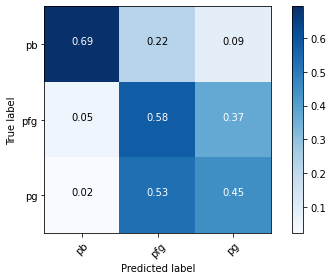

In [ ]:
cm = confusion_matrix(y[:,1], y_pred)
plot_confusion_matrix(cm,np.unique(y[:,1]))

In [ ]:
(cvk_list[0][1].shape)

(614,)

Random Forest
CV Average Scores: 
fit_time: 9.32 (+/- 0.64)
score_time: 0.03 (+/- 0.00)
test_score: 0.89 (+/- 0.09)
train_score: 1.00 (+/- 0.00)

CV Iteration Scores: 
   fit_time  test_score  train_score
0  9.436929    0.957547          1.0
1  9.255999    0.910543          1.0
2  9.531902    0.830941          1.0
3  8.704688    0.868633          1.0
4  9.495013    0.916533          1.0
5  9.515219    0.870550          1.0


Classification Report: 
              precision    recall  f1-score   support

          e1       0.98      0.98      0.98       266
          e2       0.98      0.98      0.98       252
          e3       0.78      0.78      0.78       538
          e4       0.93      0.80      0.86       614
          e5       1.00      0.97      0.99       239
          e6       0.92      0.97      0.94       314
          e7       0.81      0.78      0.79       538
      random       0.90      0.97      0.93      1115

    accuracy                           0.89      3876
   ma

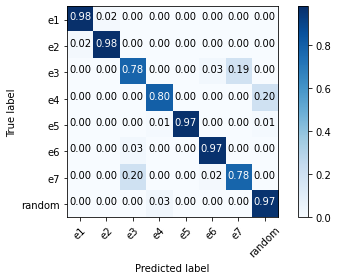

In [10]:
n_splits = 6
# use subject id to group folds
# splitter = GroupKFold(n_splits=n_splits)
# cvk = splitter.split(data['X'],data['Y'][:,1],groups=data['Y'][:,0])#X, y, groups=y[:,0])
# cvk_list = list(cvk)

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # plotting grid results from David Alvarez on Stack Overflow

    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2), len(grid_param_1))
    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2), len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1, 1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx, :], '-o', label=name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid(True)

def run_model(model, alg_name, notation):

    # Define Scoring Metric
    # scoring = ['precision_recall_fscore_support':make_scorer(precision_recall_fscore_support)
    # scoring = make_scorer(f1_score, average='macro')


    # # use subject id to group folds
    splitter = GroupKFold(n_splits=n_splits)
    cvk = splitter.split(X,y[:,1],groups=y[:,0])
    cvk_list = list(cvk)

    # print(splitter)
    # print('HELLO')
    # print(cvk)

    ##############################################################
    # Cross Validation and Calculate Multiple Metrics
    cv_scores = cross_validate(model, X[:,:],y[:,1], groups=y[:,0], cv=cvk_list, return_train_score=True, return_estimator=True)#scoring=scoring) 

    # Predictions
    y_pred = np.empty(y[:,1].shape[0],dtype=y[:,1].dtype.str)
    for idx, fold_model in enumerate(cv_scores['estimator']):
      train_idx,test_idx = cvk_list[idx]#next(cvk)
      y_pred[test_idx] = fold_model.predict(X[test_idx])

    ##############################################################
    ###################Grid Searching############################
    # # Output Results
    # print(alg_name)

    # splitter = GroupKFold(n_splits=n_splits)
    # cvk = splitter.split(data['X'],data['Y'][:,1],groups=data['Y'][:,0])
    # cvk_list = list(cvk)

    # clf = sgl.Pype([#('sensors', Sensor_Select(['A','B','C','D','E','F','G','H'],['acc','gyro','mag','quat','pres'])),
    #             ('interp', Interp(1. / 25., categorical_target=True)),
    #             ('seg', sgl.Segment()),
    #             ('ftr', sgl.FeatureRep(features=d)),
    #             ('scaler', StandardScaler()),
    #             (notation , model)])
    
    
    # par_grid = {'seg__width': [12 ,25, 50, 75, 100, 125],
    #         'seg__overlap': [0., 0.2, 0.4, 0.6]}
    
    # gs = GridSearchCV(clf, par_grid, cv=cvk_list, return_train_score=True) #scoring='f1_weighted', return_train_score=True,

    # gs.fit(data['X'], data['Y'][:,1], groups = data['Y'][:,0])

    # plot_grid_search(gs.cv_results_, par_grid['seg__width'],
    #              par_grid['seg__overlap'], 'width', 'overlap')
    # plt.show()

    # X, y = clf.fit_transform(data['X'], data['Y'])

    # return gs
          ####################################################3
    # # Output Results
    print(alg_name)

    # print(cv_scores)
    pd_cv = pd.DataFrame(cv_scores)
    # print(pd_cv)

    print("CV Average Scores: ")
    for metric in pd_cv.loc[:,pd_cv.columns != 'estimator']:
      print(metric + ": %0.2f (+/- %0.2f)" % (pd_cv[metric].mean(), pd_cv[metric].std() * 2))

    print("\nCV Iteration Scores: ")
    print(pd_cv[['fit_time','test_score','train_score']])
    print('\n')

    print("Classification Report: ")
    print(classification_report(y[:,1], y_pred))

    print("Confusion Matrix: ")
    cm = confusion_matrix(y[:,1], y_pred)
    plot_confusion_matrix(cm,np.unique(y[:,1]))

    return cv_scores

##############################################################################

cv_models = {}

# # ---- Decision Tree -----------
# from sklearn import tree

# model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=8)
# notation = 'dt'
# cv_models[notation] = run_model(model, "Decision Tree", 'dt')

# ----- Random Forest ---------------
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(bootstrap=False,
 max_depth= 57,
 max_features='auto',
 min_samples_leaf= 1,
 min_samples_split= 20,
 n_estimators= 100)
name = 'rf'
cv_models[name] = run_model(model, "Random Forest", 'rf')

# # ----- xgboost ------------
# # install xgboost
# # 'pip install xgboost' or https://stackoverflow.com/questions/33749735/how-to-install-xgboost-package-in-python-windows-platform/39811079#39811079
# from xgboost import XGBClassifier

# model = XGBClassifier()
# notation = 'xg'
# cv_models[notation] = run_model(model, "XGBoost", 'xg')

# # -------- Nearest Neighbors ----------
# from sklearn import neighbors

# model = neighbors.KNeighborsClassifier(n_neighbors=10)
# notation = 'knn'
# cv_models[notation] = run_model(model, "Nearest Neighbors Classifier", 'knn')

# ---------- SGD Classifier -----------------
# from sklearn.linear_model import SGDClassifier
# from sklearn.multiclass import OneVsRestClassifier

# model = OneVsRestClassifier(SGDClassifier())
# notation = 'sgd'
# cv_models[notation] = run_model(model, "SGD Classifier", 'sgd')

# # --------- LDA Classifer ---------
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# model = LinearDiscriminantAnalysis()
# notation = 'lda'
# cv_models[notation] = run_model(model, "Linear Discriminant Analysis", 'lda')

# # --------- Gaussian Naive Bayes ---------
# from sklearn.naive_bayes import GaussianNB

# model = GaussianNB()
# notation = 'gnb'
# cv_models[notation] = run_model(model, "Gaussian Naive Bayes", notation)

# # ------ SVM Classifier ----------------
# from sklearn.svm import SVC

# model = SVC()
# notation = 'svm'
# cv_models[notation] = run_model(model, "SVM Classifier", 'svm')

# # ----------- # 1 Neural network - Multi-layer Perceptron  ------------
# from sklearn.neural_network import MLPClassifier

# model = MLPClassifier()
# notation = 'mlpnn'
# cv_models[notation] = run_model(model, "MLP Neural network", 'mlpnn')

# # ----------- # 2 Neural network - CRNN  ------------
# model = crnn_model() #width=20, n_vars=112, n_classes=2, conv_kernel_size=10, conv_filters=128, lstm_units=100
# model = KerasClassifier(build_fn=crnn_model, epochs=10,batch_size=50,verbose=0, validation_split=0.2)
# y_prob  = run_model(model, "CRNN Neural network", 'crnn')


# # ----------- Gaussian Process Classifier  ------------
# from sklearn.gaussian_process import GaussianProcessClassifier
# model = GaussianProcessClassifier()
# run_model(model, "Gaussian Process", 'gpc')

#############################################
#Save cv_models and results in object file for future reference in needed
# np.save('/home/abdallah/Documents/Cross_Validate_Best_3_Models_Segment_exercise_no_hist_corr.npy', cv_models)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
# {'bootstrap': [True, False],
# #  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [100, 500, 1000, 1500, 2000]}



{'n_estimators': [100, 575, 1050, 1525, 2000], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
#######################################GRID SEARCHING ###################################################################
n_splits = 6
# use subject id to group folds
# splitter = GroupKFold(n_splits=n_splits)
# cvk = splitter.split(data['X'],data['Y'][:,1],groups=data['Y'][:,0])#X, y, groups=y[:,0])
# cvk_list = list(cvk)

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # plotting grid results from David Alvarez on Stack Overflow

    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2), len(grid_param_1))
    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2), len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1, 1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx, :], '-o', label=name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid(True)

def run_model(model, alg_name, notation):

    # Define Scoring Metric
    # scoring = ['precision_recall_fscore_support':make_scorer(precision_recall_fscore_support)
    # scoring = make_scorer(f1_score, average='macro')


    # # use subject id to group folds
    # splitter = GroupKFold(n_splits=n_splits)
    # cvk = splitter.split(X[0:2000,:], y[0:2000,:], groups=y[0:2000,0])

    # print(splitter)
    # print('HELLO')
    # print(cvk)

    ##############################################################
    #Cross Validation and Calculate Multiple Metrics
    # cv_scores = cross_validate(model, X[:,:],y[:,1], groups=y[:,0], cv=cvk_list, return_train_score=True, return_estimator=True)#scoring=scoring) 

    #Predictions
    # y_pred = np.empty(y[:,1].shape[0],dtype=y[:,1].dtype.str)
    # for idx, fold_model in enumerate(cv_scores['estimator']):
      # train_idx,test_idx = cvk_list[idx]#next(cvk)
      # y_pred[test_idx] = fold_model.predict(X[test_idx])

    ##############################################################
    # # Output Results
    print(alg_name)

    splitter = GroupKFold(n_splits=n_splits)
    cvk = splitter.split(data['X'],data['Y'][:,1],groups=data['Y'][:,0])
    cvk_list = list(cvk)

    # clf = sgl.Pype([#('sensors', Sensor_Select(['A','B','C','D','E','F','G','H'],['acc','gyro','mag','quat','pres'])),
    #             ('interp', Interp(1. / 25., categorical_target=True)),
    #             ('seg', sgl.Segment()),
    #             ('ftr', sgl.FeatureRep(features=d)),
    #             ('scaler', StandardScaler()),
    #             (notation , model)])
    
    
    # par_grid = {'seg__width': [12 ,25, 50, 75, 100, 125],
    #         'seg__overlap': [0., 0.2, 0.4, 0.6]}

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 6)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    # max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    # max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    par_grid = {
        'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
        'max_depth': [3, 5, 7, 10, 15],
        'min_child_weight': [1, 3, 5, 7],
        'subsample': [0.5, 0.7],
        'gamma' : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
        'colsample_bytree': [0.3, 0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror'] }
    
    gs = GridSearchCV(estimator = model, param_grid = par_grid, cv=cvk_list, n_jobs = -1,return_train_score=True) #scoring='f1_weighted', return_train_score=True,
    # gs = RandomizedSearchCV(estimator = model, param_distributions = par_grid, n_iter = 100, cv = cvk_list, random_state=42, n_jobs = -1, return_train_score=True)

    gs.fit(X, y[:,1], groups = y[:,0])

    # plot_grid_search(gs.cv_results_, par_grid['n_estimators'],
    #              par_grid['min_samples_leaf'], 'n_estimators', 'min_samples_leaf')
    # plt.show()

    # X, y = clf.fit_transform(data['X'], data['Y'])

    return gs
          ####################################################3
    # # Output Results
    # print(alg_name)

    # # print(cv_scores)
    # pd_cv = pd.DataFrame(cv_scores)
    # # print(pd_cv)

    # print("CV Average Scores: ")
    # for metric in pd_cv.loc[:,pd_cv.columns != 'estimator']:
    #   print(metric + ": %0.2f (+/- %0.2f)" % (pd_cv[metric].mean(), pd_cv[metric].std() * 2))

    # print("\nCV Iteration Scores: ")
    # print(pd_cv[['fit_time','test_score','train_score']])
    # print('\n')

    # print("Classification Report: ")
    # print(classification_report(y[:,1], y_pred))

    # print("Confusion Matrix: ")
    # cm = confusion_matrix(y[:,1], y_pred)
    # plot_confusion_matrix(cm,np.unique(y[:,1]))

    # return cv_scores

##############################################################################

cv_models = {}

# # ---- Decision Tree -----------
# from sklearn import tree

# model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=8)
# notation = 'dt'
# cv_models[notation] = run_model(model, "Decision Tree", 'dt')

# ----- Random Forest ---------------
# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier()
# name = 'rf'
# cv_models[name] = run_model(model, "Random Forest", 'rf')

# # ----- xgboost ------------
# # install xgboost
# # 'pip install xgboost' or https://stackoverflow.com/questions/33749735/how-to-install-xgboost-package-in-python-windows-platform/39811079#39811079
from xgboost import XGBClassifier

model = XGBClassifier()
notation = 'xg'
cv_models[notation] = run_model(model, "XGBoost", 'xg')

# # -------- Nearest Neighbors ----------
# from sklearn import neighbors

# model = neighbors.KNeighborsClassifier(n_neighbors=10)
# notation = 'knn'
# cv_models[notation] = run_model(model, "Nearest Neighbors Classifier", 'knn')

# ---------- SGD Classifier -----------------
# from sklearn.linear_model import SGDClassifier
# from sklearn.multiclass import OneVsRestClassifier

# model = OneVsRestClassifier(SGDClassifier())
# notation = 'sgd'
# cv_models[notation] = run_model(model, "SGD Classifier", 'sgd')

# # --------- LDA Classifer ---------
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# model = LinearDiscriminantAnalysis()
# notation = 'lda'
# cv_models[notation] = run_model(model, "Linear Discriminant Analysis", 'lda')

# # --------- Gaussian Naive Bayes ---------
# from sklearn.naive_bayes import GaussianNB

# model = GaussianNB()
# notation = 'gnb'
# cv_models[notation] = run_model(model, "Gaussian Naive Bayes", notation)

# # ------ SVM Classifier ----------------
# from sklearn.svm import SVC

# model = SVC()
# notation = 'svm'
# cv_models[notation] = run_model(model, "SVM Classifier", 'svm')

# # ----------- # 1 Neural network - Multi-layer Perceptron  ------------
# from sklearn.neural_network import MLPClassifier

# model = MLPClassifier()
# notation = 'mlpnn'
# cv_models[notation] = run_model(model, "MLP Neural network", 'mlpnn')

# # ----------- # 2 Neural network - CRNN  ------------
# model = crnn_model() #width=20, n_vars=112, n_classes=2, conv_kernel_size=10, conv_filters=128, lstm_units=100
# model = KerasClassifier(build_fn=crnn_model, epochs=10,batch_size=50,verbose=0, validation_split=0.2)
# y_prob  = run_model(model, "CRNN Neural network", 'crnn')


# # ----------- Gaussian Process Classifier  ------------
# from sklearn.gaussian_process import GaussianProcessClassifier
# model = GaussianProcessClassifier()
# run_model(model, "Gaussian Process", 'gpc')

#############################################
#Save cv_models and results in object file for future reference in needed
np.save('/home/abdallah/Documents/Grid_Search_XGBoost_exercise_no_hist_corr.npy', cv_models)

XGBoost


In [ ]:
np.save('/home/abdalrahman/Grid_Search_XGBoost_exercise_no_hist_corr.npy', cv_models)

In [ ]:
np.save('/home/abdallah/Documents/Grid_Search_window_overlap_posture_no_hist_corr_test.npy', cv_models)

TypeError: ignored

In [ ]:
import numpy as np

#Save cv_models and results in object file for future reference in needed
np.save('cv_models_posture_no_hist_corr.npy', cv_models)

In [ ]:
import numpy as np

#Load the data file if it already exists 
test = (np.load('/home/abdallah/Documents/Grid_Search_Random_Forest_exercise_no_hist_corr.npy',allow_pickle=True))[()]

In [ ]:
dir(cv_models['rf'])

['__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [11]:
cv_models['rf']['estimator'][0]

[RandomForestClassifier(bootstrap=False, max_depth=57, min_samples_split=20),
 RandomForestClassifier(bootstrap=False, max_depth=57, min_samples_split=20),
 RandomForestClassifier(bootstrap=False, max_depth=57, min_samples_split=20),
 RandomForestClassifier(bootstrap=False, max_depth=57, min_samples_split=20),
 RandomForestClassifier(bootstrap=False, max_depth=57, min_samples_split=20),
 RandomForestClassifier(bootstrap=False, max_depth=57, min_samples_split=20)]

In [ ]:
test['rf']

RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 1...
       979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991,
       992, 993, 994, 995, 996, 997, 998, 999]))],
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': ['auto', 'sqrt'],
                              

In [ ]:
cv_models['rf']['estimator'][0].predict

<bound method ForestClassifier.predict of RandomForestClassifier()>

In [ ]:
y_pred = y[:,1].copy

In [ ]:
dir(y[:,1].dtype)

['__bool__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'alignment',
 'base',
 'byteorder',
 'char',
 'descr',
 'fields',
 'flags',
 'hasobject',
 'isalignedstruct',
 'isbuiltin',
 'isnative',
 'itemsize',
 'kind',
 'metadata',
 'name',
 'names',
 'ndim',
 'newbyteorder',
 'num',
 'shape',
 'str',
 'subdtype',
 'type']

In [ ]:
y[:,1].dtype.str

'<U21'

In [ ]:
n_splits = 5
cvk = GroupKFold(n_splits)


def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # plotting grid results from David Alvarez on Stack Overflow

    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2), len(grid_param_1))
    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2), len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1, 1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx, :], '-o', label=name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid(True)

def run_model(model, alg_name, notation):
    # build the model on training data
    # model.fit(X10, y2[:,1])

    # and do a cross validation
    # scoring = ['precision_recall_fscore_support':make_scorer(precision_recall_fscore_support)


    # scoring = make_scorer(f1_score, average='macro')

    #Cross Validation and Calculate Multiple Metrics
    # cv_scores = cross_validate(model, X10,y10[:,1], groups=y10[:,0], cv=cvk, scoring=scoring) 

    # use subject id to group folds
    # splitter = GroupKFold(n_splits=n_splits)
    # cvk = splitter.split(imu, lab, groups=group)
    
    if notation == 'crnn':
      # encode class values as integers
      encoder = OneHotEncoder()
      encoder.fit(y2[:,1].reshape(-1,1))
      one_hot_encoder = encoder.transform(y2[:,1].reshape(-1,1)).toarray()

      
      # one_hot_encoder = np_utils.to_categorical(encoded_Y)

      imu = X2
      lab = y2[:,1]
      group = y2[:,0]
      # y_prob = cross_val_predict(model, imu, one_hot_encoder, groups=group ,cv=cvk, method='predict_proba')

      # print(y_prob)
      
      # Get a list of classes that matches the columns of `y_prob`
      # y_sorted = np.unique(lab)
      # Use the highest probability for predicting the label
      # indices = np.argmax(y_prob, axis=1)
      # Get the label for each sample
      # y_pred = y_sorted[indices]
      # print(y_pred)
    elif notation == 'mlpnn':
      imu = X10
      lab = y10[:,1]
      group = y10[:,0]
      # y_prob = cross_val_predict(model, imu, lab, groups=group ,cv=cvk, method='predict_proba')
      
      # Get a list of classes that matches the columns of `y_prob`
      # y_sorted = np.unique(lab)
      # Use the highest probability for predicting the label
      # indices = np.argmax(y_prob, axis=1)
      # Get the label for each sample
      # y_pred = y_sorted[indices]
    else:
      imu = X10
      lab = y10[:,1]
      group = y10[:,0]
      # y_pred = cross_val_predict(model, imu, lab, groups=group ,cv=cvk)

    # par_grid = {'epochs': [4, 8, 12, 16, 20],
    #             'batch_size': [50, 100, 200, 300,500]}
    # scorer = {'bal_acc': make_scorer(balanced_accuracy_score), 'precision': make_scorer(precision_score) ,'recall': make_scorer(recall_score), 'f1_score': make_scorer(f1_score)}

    # gs = GridSearchCV(model,
    #                   param_grid=par_grid,scoring='neg_log_loss',return_train_score=True, cv=cvk)


    # gs.fit(imu, lab)
    # return gs
    # plot_grid_search(gs.cv_results_, par_grid['epochs'],
                #  par_grid['batch_size'], 'epoch', 'baych')
    # plt.show()
    

          ####################################################3

    # #Output Results
    print(alg_name)

    # # f1_macro = f1_score(lab, y_pred, average='macro')
    # # print("F1 score: ", f1_macro)

    # if notation == 'crnn':
    #   log_loss_score = log_loss(lab, y_prob)
    #   print("Log Loss Score: ", log_loss_score)

    # if notation == 'mlpnn':
    #   log_loss_score = log_loss(lab, y_prob)
    #   print("Log Loss Score: ", log_loss_score)


    # print(classification_report(lab, y_pred))

    # cm = confusion_matrix(lab, y_pred)
    # plot_confusion_matrix(cm,np.unique(lab))

    # return y_prob
    ####################################################3
    ##########################################PIPEEEEEEEEEE
    # create a feature representation pipeline
    pipe = sgl.Pype([('seg', sgl.Segment()),
                    ('features', sgl.FeatureRep(features=d)),
                    ('scaler', StandardScaler()),
                    ('model', model)])

    # create a parameter dictionary using the sklearn API
    # note that if you want to set a parameter to a single value, it will still need to be as a list

    par_grid = {'seg__width': [10, 20, 50,100,150],
                'seg__overlap': [0., 0.3,0.5,0.7]}

    clf_gs = GridSearchCV(pipe, par_grid, cv=cvk, scoring='f1_weighted')
    clf_gs.fit(imu, lab, groups=group)

    plot_grid_search(clf_gs.cv_results_, par_grid['seg__width'],
                    par_grid['seg__overlap'], 'width', 'overlap')
    plt.show()
    ####################################################PIPEEEEEEEEEEEE

    # pd_cv = pd.DataFrame(cv_scores)

    # print("CV Average Scores: ")
    # for metric in pd_cv:
      # print(metric + ": %0.2f (+/- %0.2f)" % (pd_cv[metric].mean(), pd_cv[metric].std() * 2))

    # print("\nCV Iteration Scores: ")
    # print(pd_cv)

##############################################################################


# # ---- Decision Tree -----------
# from sklearn import tree

# model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=8)
# run_model(model, "Decision Tree", 'dt')

# ----- Random Forest ---------------
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
run_model(model, "Random Forest", 'rf')

# # ----- xgboost ------------
# # install xgboost
# # 'pip install xgboost' or https://stackoverflow.com/questions/33749735/how-to-install-xgboost-package-in-python-windows-platform/39811079#39811079
# from xgboost import XGBClassifier

# model = XGBClassifier()
# run_model(model, "XGBoost", 'xg')

# # -------- Nearest Neighbors ----------
# from sklearn import neighbors

# model = neighbors.KNeighborsClassifier(n_neighbors=10)
# run_model(model, "Nearest Neighbors Classifier", 'knn')

# ---------- SGD Classifier -----------------
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(SGDClassifier())
run_model(model, "SGD Classifier", 'sgd')

# # --------- LDA Classifer ---------
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis()
run_model(model, "Linear Discriminant Analysis", 'lda')

# # --------- Gaussian Naive Bayes ---------
# from sklearn.naive_bayes import GaussianNB

# model = GaussianNB()
# run_model(model, "Gaussian Naive Bayes", 'gnb')

# # ------ SVM Classifier ----------------
from sklearn.svm import SVC

model = SVC()
run_model(model, "SVM Classifier", 'svm')

# # ----------- # 1 Neural network - Multi-layer Perceptron  ------------
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
run_model(model, "MLP Neural network", 'mlpnn')

# # ----------- # 2 Neural network - CRNN  ------------
# model = crnn_model() #width=20, n_vars=112, n_classes=2, conv_kernel_size=10, conv_filters=128, lstm_units=100
# model = KerasClassifier(build_fn=crnn_model, epochs=10,batch_size=50,verbose=0, validation_split=0.2)
# y_prob  = run_model(model, "CRNN Neural network", 'crnn')


# # ----------- Gaussian Process Classifier  ------------
# from sklearn.gaussian_process import GaussianProcessClassifier
# model = GaussianProcessClassifier()
# run_model(model, "Gaussian Process", 'gpc')

Random Forest


In [ ]:
results = cross_validate(model, X2, encoded_Y,groups=y2[:,0] ,cv=cvk, return_train_score=True, return_estimator=True)

In [ ]:
results['estimator'][0]

AttributeError: ignored

In [ ]:
X2.shape

(12407, 25, 112)

In [ ]:
y2[:,1]

unique, counts = numpy.unique(y2[:,1], return_counts=True)
dict(zip(unique, counts))

{'pb': 962, 'pg': 2012}

In [ ]:
from tensorflow.python.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

def crnn_model(width=100, n_vars=112, n_classes=2, conv_kernel_size=7,
               conv_filters=128, lstm_units=100):
    input_shape = (width, n_vars)
    model = Sequential()
    # model.add(Conv1D(filters=conv_filters, kernel_size=conv_kernel_size,
    #                  padding='valid', activation='relu', input_shape=input_shape))
    # model.add(LSTM(units=lstm_units, dropout=0.1, recurrent_dropout=0.1))

    
    
    model.add(Conv1D(filters=conv_filters, kernel_size=conv_kernel_size, padding='valid', activation='relu',
                  input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=conv_filters, kernel_size=conv_kernel_size,
                 padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=lstm_units, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))
    model.add(LSTM(units=lstm_units, dropout=0.1, recurrent_dropout=0.1))

    model.add(Dense(n_classes, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])


    return model

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.utils import np_utils

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y3[:,1])
encoded_Y = encoder.transform(y3[:,1])

In [ ]:
encoded_Y

array([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1])

In [ ]:
dummy_y = np_utils.to_categorical(encoded_Y)

In [ ]:
print(y2[:,1][1:1500])

['pg' 'pg' 'pg' ... 'pb' 'pb' 'pb']


In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(y2[:,1].reshape(-1,1))
encoded_Y = encoder.transform(y2[:,1].reshape(-1,1)).toarray()

NameError: ignored

In [ ]:
      # encode class values as integers
      encoder = OneHotEncoder()
      encoder.fit(y3[:,1].reshape(-1,1))
      encoded_Y = encoder.transform(y3[:,1].reshape(-1,1)).toarray()

      
      # one_hot_encoder = np_utils.to_categorical(y2[:,1])

In [ ]:
one_hot_encoder = np_utils.to_categorical(encoded_Y)

In [ ]:
one_hot_encoder.shape

(57, 2, 2)

In [ ]:
one_hot_encoder

In [ ]:
y_pred = (encoder.inverse_transform(y_prob)).reshape(1,-1)[0]

In [ ]:
y_sorted = np.unique(y2[:,1])
indices = np.argmax(y_prob, axis=1)
y_sorted[indices]

array(['pg', 'pg', 'pg', ..., 'pg', 'pg', 'pg'], dtype='<U21')

In [ ]:
      # Get a list of classes that matches the columns of `y_prob`
      y_sorted = np.unique(y2[:,1])
      # Use the highest probability for predicting the label
      indices = np.argmax(y_prob, axis=1)
      # Get the label for each sample
      y_pred = y_sorted[indices]
      print(y_pred.shape)

(2974,)


In [ ]:
 print(y_prob[2000:2500])

              precision    recall  f1-score   support

          pb       0.00      0.00      0.00       962
          pg       0.68      1.00      0.81      2012

    accuracy                           0.68      2974
   macro avg       0.34      0.50      0.40      2974
weighted avg       0.46      0.68      0.55      2974



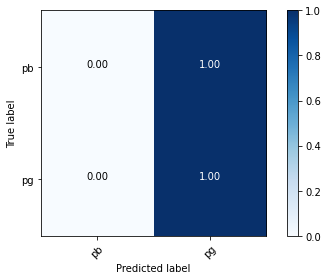

In [ ]:
    print(classification_report(y2[:,1], y_pred))

    cm = confusion_matrix(y2[:,1], y_pred)
    plot_confusion_matrix(cm,np.unique(y2[:,1]))

In [ ]:
# encoded_Y = encoder.transform(y2[:,1])

ValueError: ignored

In [ ]:
y_int = []

for ex in y10[:,1]:
    if ex == 'e1':
        y_int.append(1)
    elif ex == 'e2':
        y_int.append(2)
    elif ex == 'e3':
        y_int.append(3)
    elif ex == 'e4':
        y_int.append(4)
    elif ex == 'e5':
        y_int.append(5)
    elif ex == 'e6':
        y_int.append(6)
    elif ex == 'e7':
        y_int.append(7)
    elif ex == 'pg':
        y_int.append([1,0])
    elif ex == 'pfg':
        y_int.append(9)
    elif ex == 'pb':
        y_int.append([0,1])
    elif ex == 'random':
        y_int.append(11)
    else:
        print('Something is wrong')
# y[:,1] == 'e5'

In [ ]:
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Conv1D, Input, BatchNormalization, Dropout, Lambda, Activation, GlobalAveragePooling1D
import tensorflow.python.keras.backend as K


def fcn(input_shape, conv_layers=({'f': 128, 'k': 8, 's': 1}, {'f': 256, 'k': 5, 's': 1}, {'f': 128, 'k': 3, 's': 1}),
        dropout=0.3, normalize=True, embedding_size=None):
    """
    Creates fully convolutional neural (FCN) network architecture described in: https://arxiv.org/abs/2001.05517
    :param input_shape: tuple (2)
        segment shape (width, n_channels)
    :param conv_layers: tuple of dicts
        describe conv layers with f: filters, k: kernel size, s: stride
    :param dropout: float
        dropout ratio applied at each layer
    :param normalize: bool
        apply l2 normalization
    :param embedding_size: integer, optional
        defines embedding size (number of filters for last CNN layer)
    :return: keras model
        the fcn model
    """

    input_layer = Input(shape=input_shape)
    layer = input_layer

    if embedding_size:
        conv_layers[-1]['f'] = embedding_size

    for lp in conv_layers:
        layer = Conv1D(filters=lp['f'], kernel_size=lp['k'], strides=lp['s'], padding='same')(layer)
        layer = BatchNormalization()(layer)
        layer = Activation('relu')(layer)

        if dropout:
            layer = Dropout(rate=dropout)(layer)

    layer = GlobalAveragePooling1D()(layer)

    if normalize:
        layer = Lambda(lambda x: K.l2_normalize(x, axis=1))(layer)

    return Model(inputs=input_layer, outputs=layer)

In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support



gs = GridSearchCV(model,
                  param_grid={'batch_size': range(50, 500, 50)},
                  scoring=scorer, refit='AUC', return_train_score=True)

TypeError: ignored

In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [ ]:
# The scorers can be either one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid={'min_samples_split': range(2, 403, 10)},
                  scoring=scoring, refit='AUC', return_train_score=True)
gs.fit(X, y)
results = gs.cv_results_

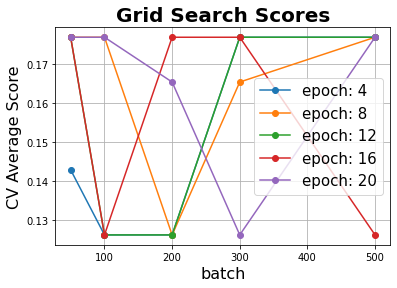

In [ ]:
    par_grid = {'epochs': [4, 8, 12, 16, 20],
                'batch_size': [50, 100, 200, 300,500]}
plot_grid_search(gs.cv_results_,
                 par_grid['batch_size'], par_grid['epochs'], 'batch','epoch',)
plt.show()

In [ ]:

gs.cv_results_

{'mean_fit_time': array([5.31818044, 8.01842868, 4.06305051, 5.52656817, 3.51270664,
        4.22615862]),
 'std_fit_time': array([0.55105364, 0.97170937, 0.02822256, 0.16739273, 0.17056096,
        0.04253888]),
 'mean_score_time': array([0.33999085, 0.33801198, 0.27825212, 0.28273487, 0.25796533,
        0.25352108]),
 'std_score_time': array([0.02749944, 0.01614904, 0.01450396, 0.01190662, 0.0066061 ,
        0.00783765]),
 'param_batch_size': masked_array(data=[50, 50, 100, 100, 200, 200],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_epochs': masked_array(data=[4, 8, 4, 8, 4, 8],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'batch_size': 50, 'epochs': 4},
  {'batch_size': 50, 'epochs': 8},
  {'batch_size': 100, 'epochs': 4},
  {'batch_size': 100, 'epochs': 8},
  {'batch_size': 200, 'epochs': 4},
  {'batch_size': 200, 'epoch

In [ ]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # plotting grid results from David Alvarez on Stack Overflow

    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2), len(grid_param_1))
    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2), len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1, 1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx, :], '-o', label=name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid(True)

In [ ]:
def grid_plot(results, scoring):  
  plt.figure(figsize=(13, 13))
  plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
            fontsize=16)

  plt.xlabel("min_samples_split")
  plt.ylabel("Score")

  ax = plt.gca()
  ax.set_xlim(0, 402)
  ax.set_ylim(0.73, 1)

  # Get the regular numpy array from the MaskedArray
  X_axis = np.array(results['param_min_samples_split'].data, dtype=float)

  for scorer, color in zip(sorted(scoring), ['g', 'k', 'r', 'b']):
      for sample, style in (('train', '--'), ('test', '-')):
          sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
          sample_score_std = results['std_%s_%s' % (sample, scorer)]
          ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                          sample_score_mean + sample_score_std,
                          alpha=0.1 if sample == 'test' else 0, color=color)
          ax.plot(X_axis, sample_score_mean, style, color=color,
                  alpha=1 if sample == 'test' else 0.7,
                  label="%s (%s)" % (scorer, sample))

      best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
      best_score = results['mean_test_%s' % scorer][best_index]

      # Plot a dotted vertical line at the best score for that scorer marked by x
      ax.plot([X_axis[best_index], ] * 2, [0, best_score],
              linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

      # Annotate the best score for that scorer
      ax.annotate("%0.2f" % best_score,
                  (X_axis[best_index], best_score + 0.005))

  plt.legend(loc="best")
  plt.grid(False)
  plt.show()

MISC Code below --Maybe

In [ ]:
"""
===========================
Resampling Time Series Data
===========================
This is a basic example using the pipeline to learn resample a time series
This may be useful for resampling irregularly sampled time series, or for determining
an optimal sampling frequency for the data
"""
# Author: David Burns
# License: BSD

import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from seglearn.datasets import load_watch
from seglearn.pipe import Pype
from seglearn.split import TemporalKFold
from seglearn.transform import FeatureRep, Segment, Interp


def calc_segment_width(params):
    # number of samples in a 2 second period
    period = params['interp__sample_period']
    return int(2. / period)


# seed RNGESUS
np.random.seed(123124)

# load the data
data_test = load_watch()

X_test = data_test['X']
y_test = data_test['y']

# # I am adding in a column to represent time (50 Hz sampling), since my data doesn't include it
# # the Interp class assumes time is the first column in the series
# X = np.array([np.column_stack([np.arange(len(X[i])) / 25., X[i]]) for i in np.arange(len(X))])

# clf = Pype([('interp', Interp(1. / 25., categorical_target=True)),
#             ('segment', Segment(width=100)),
#             ('features', FeatureRep()),
#             ('scaler', StandardScaler()),
#             ('rf', RandomForestClassifier(n_estimators=20))])

# # split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# clf.fit(X_train, y_train)
# score = clf.score(X_test, y_test)

# print("N series in train: ", len(X_train))
# print("N series in test: ", len(X_test))
# print("N segments in train: ", clf.N_train)
# print("N segments in test: ", clf.N_test)
# print("Accuracy score: ", score)

# # lets try a few different sampling periods
# # temporal splitting of data
# splitter = TemporalKFold(n_splits=3)
# Xs, ys, cv = splitter.split(X, y)

# # here we use a callable parameter to force the segmenter width to equal 2 seconds
# # note this is an extension of the sklearn api for setting class parameters
# par_grid = {'interp__sample_period': [1. / 5., 1. / 10., 1. / 25., 1. / 50.],
#             'segment__width': [calc_segment_width]}

# clf = GridSearchCV(clf, par_grid, cv=cv)
# clf.fit(Xs, ys)
# scores = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']

# plt.plot(par_grid['interp__sample_period'], scores, '-o')
# plt.title("Grid Search Scores")
# plt.xlabel("Sample Period [s]")
# plt.ylabel("CV Average Score")
# plt.fill_between(par_grid['interp__sample_period'], scores - stds, scores + stds, alpha=0.2,
#                  color='navy')
# plt.show()

In [ ]:
X_test[3].shape

(1597, 6)

In [ ]:
cols  = list(all_signals.columns)
cols[0], cols[1] = cols[1] , cols[0]
all_signals[cols]

In [ ]:
clf = Pype([('interp', Interp(1. / 100., categorical_target=True)),
            ('segment', Segment(width=100)),
            ('features', FeatureRep()),
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(n_estimators=20))])

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


In [ ]:
clf4 = sgl.Pype([('interp', Interp(1. / 25., categorical_target=True)),
                #  ('segment', sgl.Segment(width=20,overlap=0.3))])
X20, y20 = clf4.fit_transform(X_new, y3)

SyntaxError: ignored

DATA STATS - AGGREGATED
{'n_series': 140, 'n_classes': 7, 'n_TS_vars': 6, 'n_context_vars': 2, 'Total_Time': 4882.04, 'Series_Time_Mean': 34.87171428571428, 'Series_Time_Std': 8.757850351285423, 'Series_Time_Range': (18.94, 52.36)}

DATA STATS - BY CLASS
  Class_labels  n_series  Total_Time  Series_Time_Mean  Series_Time_Std  \
0          PEN        20      532.44            26.622         2.720845   
1          ABD        20      798.10            39.905         8.055554   
2          FEL        20      809.96            40.498         8.772099   
3           IR        20      747.90            37.395         9.085212   
4           ER        20      752.08            37.604         7.983878   
5         TRAP        20      611.56            30.578         6.099252   
6          ROW        20      630.00            31.500         5.957100   

   Series_Time_Min  Series_Time_Max  
0            21.28            31.10  
1            22.48            49.10  
2            22.30            

/home/abdallah/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


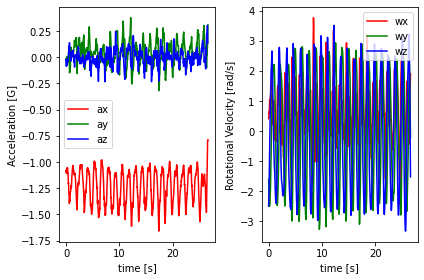

In [ ]:
# License: BSD

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from seglearn.base import TS_Data
from seglearn.datasets import load_watch
from seglearn.util import check_ts_data, ts_stats

data = load_watch()

y = data['y']
Xt = data['X']
fs = 50  # sampling frequency

# create time series data object with no contextual variables

check_ts_data(Xt)

# create time series data object with 2 contextual variables
Xs = np.column_stack([data['side'], data['subject']])
X = TS_Data(Xt, Xs)
check_ts_data(X)

# recover time series and contextual variables
Xt = X.ts_data
Xs = X.context_data

# generate some statistics from the time series data
results = ts_stats(X, y, fs=fs, class_labels=data['y_labels'])
print("DATA STATS - AGGREGATED")
print(results['total'])
print("")
print("DATA STATS - BY CLASS")
print(pd.DataFrame(results['by_class']))

# plot an instance from the data set
# this plot shows 6-axis inertial sensor data recorded by someone doing shoulder pendulum exercise
Xt0 = Xt[0]
f, axes = plt.subplots(nrows=1, ncols=2)
t = np.arange(len(Xt0)) / fs
axes[0].plot(t, Xt0[:, 0], 'r-')
axes[0].plot(t, Xt0[:, 1], 'g-')
axes[0].plot(t, Xt0[:, 2], 'b-')
axes[0].set_xlabel('time [s]')
axes[0].set_ylabel('Acceleration [G]')
axes[0].legend(data['X_labels'][0:3])

axes[1].plot(t, Xt0[:, 3], 'r-')
axes[1].plot(t, Xt0[:, 4], 'g-')
axes[1].plot(t, Xt0[:, 5], 'b-')
axes[1].set_xlabel('time [s]')
axes[1].set_ylabel('Rotational Velocity [rad/s]')
axes[1].legend(data['X_labels'][3:6])

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import time, datetime, csv, signal
import os
import re
import numpy as np
from seglearn.transform import InterpLongToWide
from seglearn.transform import FeatureRep, Segment, Interp
from seglearn.pipe import Pype


acc_col_label = ['X-Axis (g)','Y-Axis (g)','Z-Axis (g)']
gyro_col_label =['X-Axis (deg/s)','Y-Axis (deg/s)','Z-Axis (deg/s)']
mag_col_label = ['X-Axis (T)','Y-Axis (T)','Z-Axis (T)']
pres_col_label = ['Pressure (Pa)']
quat_col_label = ['W-Axis','X-Axis (i)','Y-Axis (j)','Z-Axis (k)'] #should be i j k


sensor_type_col_labels = [acc_col_label,gyro_col_label,mag_col_label,quat_col_label,pres_col_label]


A = "C7:E1:38:1F:C0:DE"
B = "F4:04:52:A2:CB:59"
C = "E3:62:1F:8B:81:B7"
D = "E8:9C:A5:A3:8A:60"
E = "F9:0E:1C:DA:D4:1D"
F = "CD:A5:4D:78:A1:B4"
G = "EF:AA:47:DC:45:44"
H = "CD:78:F1:6B:D8:67"

def signal_dataframe(folder):
  items = folder.split('/')
  session_name = items[1]+"_"+items[2]+"_"+items[3]+"_"+items[4]
  '''###
  MERGE CODE
  '''###
  for id_sensor , (sensor,sensor_name) in enumerate(zip([A,B,C,D,E,F,G,H],['A','B','C','D','E','F','G','H'])):
    if 'reps' in items:
        ending = "_"+items[6]+".csv"
    else:
        ending = ".csv"


    dfa = pd.read_csv(folder+session_name+'_'+sensor.replace(':','')+'_acc'+ending) #Reading the dataset in a dataframe using Pandas
    dfg = pd.read_csv(folder+session_name+"_"+sensor.replace(':','')+"_gyro"+ending) #Reading the dataset in a dataframe using Pandas
    dfm = pd.read_csv(folder+session_name+"_"+sensor.replace(':','')+"_mag"+ending) #Reading the dataset in a dataframe using Pandas
    dfq = pd.read_csv(folder+session_name+"_"+sensor.replace(':','')+"_quat"+ending) #Reading the dataset in a dataframe using Pandas
    dfp = pd.read_csv(folder+session_name+"_"+sensor.replace(':','')+"_pres"+ending) #Reading the dataset in a dataframe using Pandas

    for signal_id , signal in enumerate([dfa,dfg,dfm,dfq,dfp]):
      #Drop Time column
      signal.drop(columns=['time (-07:00)'],inplace=True)

      #Switch order of elapsed time and epoch
      cols  = list(signal.columns)
      cols[0], cols[1] = cols[1] , cols[0]
      signal = signal[cols]

      #Interpolate the data to have all signals to 25Hz
      clf = Pype([('interp', Interp(1. / 25., categorical_target=True))])
      # print(signal[cols].columns.values[1:])
      # test = ([dfa.to_numpy(),dfg.to_numpy(),dfm.to_numpy(),dfq.to_numpy(),dfp.to_numpy()])
      signal_arr, _ = clf.fit_transform([signal.to_numpy()],[0])
      signal_arr = pd.DataFrame(data=signal_arr[0],columns=signal[cols].columns.values[1:])
      if signal_id == 0:
        dfa =  signal_arr
      elif signal_id == 1:
        dfg =  signal_arr
      elif signal_id == 2:
        dfm =  signal_arr
      elif signal_id == 3:
        dfq =  signal_arr
      else:
        dfp =  signal_arr

    #Synchronizing and merging the signals together
    test1a = pd.merge_asof(dfa, dfg, on='epoch (ms)')
    test2a = pd.merge_asof(test1a, dfm, on='epoch (ms)')
    test3a = pd.merge_asof(test2a, dfq, on='epoch (ms)')
    test4a = pd.merge_asof(test3a, dfp, on='epoch (ms)')

    df = test4a

    #Add sensor name to each of its corresponding columns
    for signal in sensor_type_col_labels:
      for axis in signal:
        df.rename(columns = {axis:axis + " - "+ sensor_name}, inplace = True)
        
    if id_sensor == 0:
      full_df = df.copy()
    else:
      full_df = pd.merge_asof(full_df, df, on='epoch (ms)')

  # Remove any NA rows and reset index before returning array
  full_df.dropna(inplace=True)
  full_df.reset_index(drop=True, inplace=True)
  return full_df
folder = "Data/p0/s2/e1/r1/"
all_signals = signal_dataframe(folder)
print(all_signals)


In [ ]:
y_labels = ['e1','e2','e3','e4','e5','e6','e7','pg','pfg','pb','rand'] #'pg','pfg','pb',

In [ ]:
#                             if exercise == 'pg':
#                                 continue;
#                             elif exercise == 'pfg':
#                                 continue;
#                             elif exercise == 'pb':
#                                 continue;
#                             for sig_idx, signal in enumerate(sensor_type_col_labels):
#                                 for axis_idx, axis in enumerate(signal):
#                                     data['X'].append(all_signals[axis])


#                                     if sig_idx == 0:
#                                         data['Signal'].append('Acc')
#                                         if axis_idx == 0:
#                                             data['Axis'].append('X')
#                                         elif axis_idx == 1:
#                                             data['Axis'].append('Y')
#                                         else:
#                                             data['Axis'].append('Z')
#                                     elif sig_idx == 1:
#                                         data['Signal'].append('Gyro')
#                                         if axis_idx == 0:
#                                             data['Axis'].append('X')
#                                         elif axis_idx == 1:
#                                             data['Axis'].append('Y')
#                                         else:
#                                             data['Axis'].append('Z')
#                                     elif sig_idx == 2:
#                                         data['Signal'].append('Mag')
#                                         if axis_idx == 0:
#                                             data['Axis'].append('X')
#                                         elif axis_idx == 1:
#                                             data['Axis'].append('Y')
#                                         else:
#                                             data['Axis'].append('Z')
#                                     elif sig_idx == 3:
#                                         data['Signal'].append('Quat')
#                                         if axis_idx == 0:
#                                             data['Axis'].append('W')
#                                         elif axis_idx == 1:
#                                             data['Axis'].append('X')
#                                         elif axis_idx == 2:
#                                             data['Axis'].append('Y')
#                                         else:
#                                             data['Axis'].append('Z')
#                                     else:
#                                         data['Signal'].append('Pres')
#                                         data['Axis'].append('Z')